<a href="https://colab.research.google.com/github/PrathamKumar125/3DSegmentation_VNET/blob/master/VNET_3DSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
!pip -q install nibabel scikit-learn segmentation-models-3D tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.3.1 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [2]:
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
from keras import metrics
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum
from keras.layers import Lambda, RepeatVector, Reshape
from keras.layers import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose
from keras.layers import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import sklearn.model_selection as sk

from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.layers import PReLU

import shutil
import os
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
import numpy as np

import nibabel as nib
from PIL import Image


# **Data Loading**

In [3]:
!kaggle datasets download -d prathamkumar0011/miccai-flare22-challenge-dataset

Dataset URL: https://www.kaggle.com/datasets/prathamkumar0011/miccai-flare22-challenge-dataset
License(s): CC0-1.0
100% 1.46G/1.46G [01:11<00:00, 20.2MB/s]
100% 1.46G/1.46G [01:11<00:00, 21.9MB/s]


In [4]:
!unzip -q miccai-flare22-challenge-dataset.zip

# **Data Preparation**

In [5]:
def copy_and_rename_images(source_directory, destination_directory, substring_to_remove='_0000'):
    # Ensure the destination directory exists
    os.makedirs(destination_directory, exist_ok=True)

    # iterate all files in the source directory
    for filename in os.listdir(source_directory):
        if substring_to_remove in filename:
            # replacing the specified substring with an empty string
            new_filename = filename.replace(substring_to_remove, '')

            old_file_path = os.path.join(source_directory, filename)
            new_file_path = os.path.join(destination_directory, new_filename)

            # Copy and rename the file
            shutil.copy(old_file_path, new_file_path)

            print(f'Copied and renamed: {filename} -> {new_filename}')

source_dir = '/content/FLARE22Train/FLARE22Train/images'
destination_dir = 'dataset/images'
copy_and_rename_images(source_dir, destination_dir)

def copy_label_dirs_with_files(base_directory, destination_directory):
    # Ensure the destination directory exists
    os.makedirs(destination_directory, exist_ok=True)

    # iterate all sub-directory in the directory
    for subdir in os.listdir(base_directory):
        subdir_path = os.path.join(base_directory, subdir)

        if os.path.isdir(subdir_path):
            # iterate all files in the sub-directory
            for item in os.listdir(subdir_path):
                item_path = os.path.join(subdir_path, item)
                dest_item_path = os.path.join(destination_directory, item)

                # Copy file
                shutil.copy2(item_path, dest_item_path)
                print(f"Copied file: {item_path} -> {dest_item_path}")

base_dir = '/content/FLARE22Train/FLARE22Train/labels'
dest_dir = 'dataset/labels'
copy_label_dirs_with_files(base_dir, dest_dir)

Copied and renamed: FLARE22_Tr_0035_0000.nii -> FLARE22_Tr_0035.nii
Copied and renamed: FLARE22_Tr_0049_0000.nii -> FLARE22_Tr_0049.nii
Copied and renamed: FLARE22_Tr_0019_0000.nii -> FLARE22_Tr_0019.nii
Copied and renamed: FLARE22_Tr_0034_0000.nii -> FLARE22_Tr_0034.nii
Copied and renamed: FLARE22_Tr_0004_0000.nii -> FLARE22_Tr_0004.nii
Copied and renamed: FLARE22_Tr_0047_0000.nii -> FLARE22_Tr_0047.nii
Copied and renamed: FLARE22_Tr_0013_0000.nii -> FLARE22_Tr_0013.nii
Copied and renamed: FLARE22_Tr_0026_0000.nii -> FLARE22_Tr_0026.nii
Copied and renamed: FLARE22_Tr_0005_0000.nii -> FLARE22_Tr_0005.nii
Copied and renamed: FLARE22_Tr_0040_0000.nii -> FLARE22_Tr_0040.nii
Copied and renamed: FLARE22_Tr_0007_0000.nii -> FLARE22_Tr_0007.nii
Copied and renamed: FLARE22_Tr_0021_0000.nii -> FLARE22_Tr_0021.nii
Copied and renamed: FLARE22_Tr_0043_0000.nii -> FLARE22_Tr_0043.nii
Copied and renamed: FLARE22_Tr_0036_0000.nii -> FLARE22_Tr_0036.nii
Copied and renamed: FLARE22_Tr_0023_0000.nii -> 

In [6]:
def split_3d_dataset(image_dir, label_dir, train_dir, test_dir, test_size=0.2):

    # Create directories for train and test sets
    os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(test_dir, 'labels'), exist_ok=True)

    # List all image files (assuming all files are NIfTI format)
    image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    # Split image files into train and test sets
    train_files, test_files = train_test_split(image_files, test_size=test_size, random_state=42)

    # Helper function to copy files
    def copy_files(file_list, src_image_dir, src_label_dir, dst_image_dir, dst_label_dir):
        for file_name in file_list:
            # Define source and destination paths
            src_image_path = os.path.join(src_image_dir, file_name)
            src_label_path = os.path.join(src_label_dir, file_name.replace('.nii.gz', '_label.nii.gz'))
            dst_image_path = os.path.join(dst_image_dir, file_name)
            dst_label_path = os.path.join(dst_label_dir, file_name.replace('.nii.gz', '_label.nii.gz'))

            # Copy images and labels
            if os.path.exists(src_image_path):
                shutil.copy(src_image_path, dst_image_path)
            if os.path.exists(src_label_path):
                shutil.copy(src_label_path, dst_label_path)

    # Copy files to train and test directories
    copy_files(train_files, image_dir, label_dir, os.path.join(train_dir, 'images'), os.path.join(train_dir, 'labels'))
    copy_files(test_files, image_dir, label_dir, os.path.join(test_dir, 'images'), os.path.join(test_dir, 'labels'))

    print(f"Dataset split complete. Training set: {len(train_files)} files, Testing set: {len(test_files)} files.")


src_images_dir = 'dataset/images'
src_labels_dir = 'dataset/labels'
dest_train_images_dir = 'dataset/train'
dest_test_images_dir = 'dataset/test'
split_3d_dataset(src_images_dir, src_labels_dir, dest_train_images_dir, dest_test_images_dir)

Dataset split complete. Training set: 40 files, Testing set: 10 files.


# **Data Preprocessing**

In [7]:
train_img_dir = "/content/dataset/train/images/"
train_mask_dir = "/content/dataset/train/labels/"

train_img_list = sorted(os.listdir(train_img_dir))
train_mask_list =  sorted(os.listdir(train_mask_dir))
batch_size = 2


In [48]:
import os
import nibabel as nib
import numpy as np
import scipy.ndimage

def load_img(img_dir, img_list):
    images = []
    for image_name in img_list:
        if image_name.endswith('.nii'):
            # Use os.path.join to correctly concatenate paths
            file_path = os.path.join(img_dir, image_name)
            print("Loading file:", file_path)

            img = nib.load(file_path)
            img_data = img.get_fdata()

            # Resize to 128x128x128
            target_shape = (128, 128, 128)
            original_shape = img_data.shape[:3]
            resize_factors = np.array(target_shape) / np.array(original_shape)
            resized_img_data = scipy.ndimage.zoom(img_data, resize_factors, order=1)

            # Pad or crop to ensure the shape is exactly 128x128x128
            slices = tuple(slice(0, min(t, s)) for t, s in zip(target_shape, resized_img_data.shape))
            padded_img_data = np.zeros(target_shape)
            padded_img_data[tuple(slice(0, s) for s in resized_img_data.shape)] = resized_img_data[slices]

            # Expand to 4 channels
            if padded_img_data.ndim == 3:  # Single channel
                expanded_img_data = np.stack([padded_img_data] * 4, axis=-1)
            else:  # Multiple channels
                channels = padded_img_data.shape[-1]
                expanded_img_data = np.zeros((128, 128, 128, 4))
                expanded_img_data[..., :channels] = padded_img_data

            images.append(expanded_img_data)

    return np.array(images)

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            # Load images and masks in batches
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield X, Y  # Yield images and masks as a tuple

            batch_start += batch_size
            batch_end += batch_size



In [49]:
train_img_datagen = imageLoader(train_img_dir, train_img_list,  train_mask_dir, train_mask_list, batch_size)
img, msk = train_img_datagen.__next__()

Loading file: /content/dataset/train/images/FLARE22_Tr_0005.nii
Loading file: /content/dataset/train/images/FLARE22_Tr_0006.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0005.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0006.nii


In [50]:
print(img.shape)
print(msk.shape)

(2, 128, 128, 128, 4)
(2, 128, 128, 128, 4)


# **Data Visualization**

In [51]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=2)

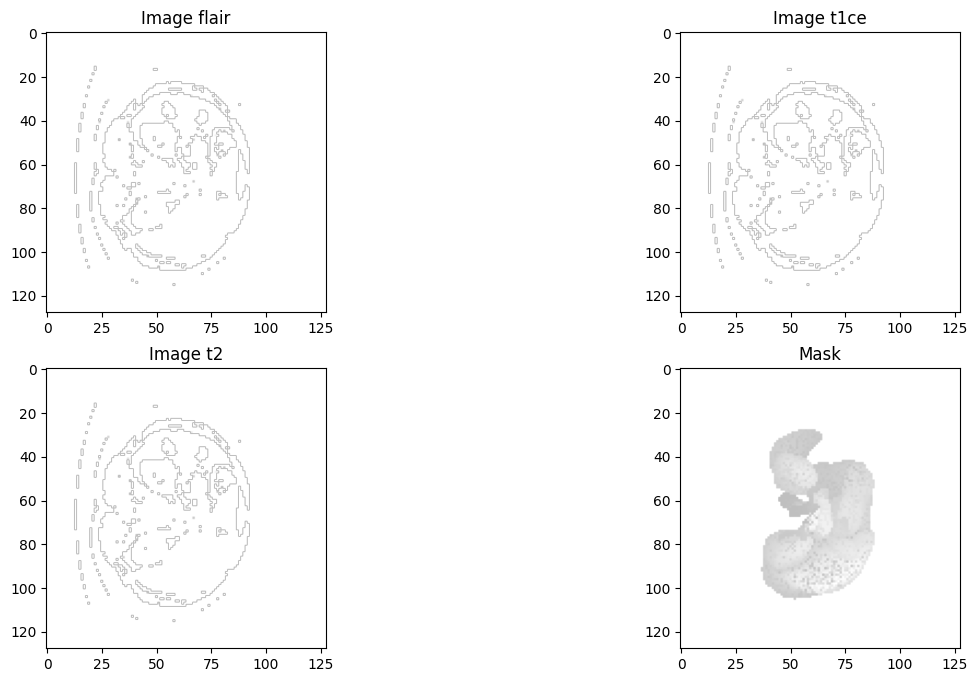

In [52]:
n_slice = random.randint(0, test_mask.shape[1]-1)  # Access the second dimension (index 1)
n_slice = 55
plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.imshow(test_img[:, :, n_slice], cmap='gray')  # Remove the extra index
plt.title('Image flair')
plt.subplot(222)
# Assuming you have other slices you want to display, adjust accordingly
plt.imshow(test_img[:, :, n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:, :, n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:, :], cmap='gray')  # Display the entire 2D mask
plt.title('Mask')
plt.show()

# **Train test Split**

In [53]:
img_list = sorted(os.listdir(train_img_dir))
print(len(img_list))
msk_list = sorted(os.listdir(train_mask_dir))
print(len(msk_list))


40
40


In [56]:
train_img_list = sorted(os.listdir("/content/dataset/train/images"))
train_mask_list =  sorted(os.listdir("/content/dataset/train/labels"))

train_img_data, val_img_data, train_mask_data, val_mask_data = sk.train_test_split(
    train_img_list,train_mask_list , test_size=0.2, random_state=42, shuffle = True
)

In [57]:
batch_size=2
train_img_datagen = imageLoader(train_img_dir,train_img_list, train_mask_dir, train_mask_list, batch_size)

# Use the val_img_data variable (containing the list of validation images)
val_img_datagen = imageLoader(val_img_data, val_img_data, val_mask_data, val_mask_data, batch_size)

In [58]:
img, msk = train_img_datagen.__next__()
print(img.shape)
print(msk.shape)

Loading file: /content/dataset/train/images/FLARE22_Tr_0005.nii
Loading file: /content/dataset/train/images/FLARE22_Tr_0006.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0005.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0006.nii
(2, 128, 128, 128, 4)
(2, 128, 128, 128, 4)


# **Model architecture**

In [59]:
!python3 -m pip -q install tensorflow[and-cuda]
# Verify the installation:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.5/20.5 MB 36.3 MB/s eta 0:00:00
2024-09-02 11:04:36.860013: E external/local_

In [60]:
import tensorflow as tf
import tensorflow.keras as keras
import segmentation_models_3D as sm
tf.keras.backend.set_floatx('float64')

In [69]:
def conv_block(input_mat,num_filters,kernel_size,batch_norm):
  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(input_mat)
  if batch_norm:
    X = BatchNormalization()(X)

  X = Activation('relu')(X)

  X = Conv3D(num_filters,kernel_size=(kernel_size,kernel_size,kernel_size),strides=(1,1,1),padding='same')(X)
  if batch_norm:
    X = BatchNormalization()(X)

  X = Activation('relu')(X)

  X = add([input_mat,X]);

  return X


def Vnet_3d(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, n_filters = 16, dropout = 0.2, batch_norm = True):
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
  input_img = inputs
  c1 = Conv3D(n_filters,kernel_size = (5,5,5) , strides = (1,1,1) , padding='same')(input_img)
  c2 = Conv3D(n_filters*2,kernel_size = (2,2,2) , strides = (2,2,2) , padding = 'same' )(c1)
  c3 = conv_block(c2 , n_filters*2,5,True)

  p3 = Conv3D(n_filters*4,kernel_size = (2,2,2) , strides = (2,2,2), padding = 'same')(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv_block(p3, n_filters*4,5,True)
  p4 = Conv3D(n_filters*8,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv_block(p4, n_filters*8,5,True)
  p6 = Conv3D(n_filters*16,kernel_size = (2,2,2) , strides = (2,2,2) , padding='same')(c5)
  p6 = Dropout(dropout)(p6)
  p7 = conv_block(p6,n_filters*16,5,True)

  u6 = Conv3DTranspose(n_filters*8, (2,2,2), strides=(2, 2, 2), padding='same')(p7);
  u6 = concatenate([u6,c5]);
  c7 = conv_block(u6,n_filters*16,5,True)
  c7 = Dropout(dropout)(c7)
  u7 = Conv3DTranspose(n_filters*4,(2,2,2),strides = (2,2,2) , padding= 'same')(c7);


  u8 = concatenate([u7,c4]);
  c8 = conv_block(u8,n_filters*8,5,True)
  c8 = Dropout(dropout)(c8)
  u9 = Conv3DTranspose(n_filters*2,(2,2,2),strides = (2,2,2) , padding= 'same')(c8);

  u9 = concatenate([u9,c3]);
  c9 = conv_block(u9,n_filters*4,5,True)
  c9 = Dropout(dropout)(c9)
  u10 = Conv3DTranspose(n_filters,(2,2,2),strides = (2,2,2) , padding= 'same')(c9);


  u10 = concatenate([u10,c1]);
  c10 = Conv3D(n_filters*2,kernel_size = (5,5,5),strides = (1,1,1) , padding = 'same')(u10);
  c10 = Dropout(dropout)(c10)
  c10 = add([c10,u10]);


  #c9 = conv_block(u9,n_filters,3,batch_norm)
  outputs = Conv3D(4, (1,1,1), activation='softmax')(c10)
  model = Model(inputs=[input_img], outputs=[outputs])
    #compile model outside of this function to make it flexible.
  return model
model = Vnet_3d(128, 128, 128, 4)

In [70]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 128, 128, 128,  │              0 │ -                      │
│ (InputLayer)              │ 4)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_63 (Conv3D)        │ (None, 128, 128, 128,  │          8,016 │ input_layer_4[0][0]    │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_64 (Conv3D)        │ (None, 64, 64, 64, 32) │          4,128 │ conv3d_63[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_65 (Conv3D)        │ (None, 64, 64, 64, 32) │        128,032 │ conv3d_64[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 64, 64, 64, 32) │            128 │ conv3d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_42             │ (None, 64, 64, 64, 32) │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_66 (Conv3D)        │ (None, 64, 64, 64, 32) │        128,032 │ activation_42[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 64, 64, 64, 32) │            128 │ conv3d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_43             │ (None, 64, 64, 64, 32) │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_24 (Add)              │ (None, 64, 64, 64, 32) │              0 │ conv3d_64[0][0],       │
│                           │                        │                │ activation_43[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_67 (Conv3D)        │ (None, 32, 32, 32, 64) │         16,448 │ add_24[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 32, 32, 32, 64) │              0 │ conv3d_67[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_68 (Conv3D)        │ (None, 32, 32, 32, 64) │        512,064 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 32, 32, 32, 64) │            256 │ conv3d_68[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_44             │ (None, 32, 32, 32, 64) │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├──────────────────────

 Total params: 44,192,516 (337.16 MB)

 Trainable params: 44,188,804 (337.13 MB)

 Non-trainable params: 3,712 (29.00 KB)

In [71]:
print(model.input_shape)
print(model.output_shape)

(None, 128, 128, 128, 4)
(None, 128, 128, 128, 4)


In [72]:
steps_per_epoch = (len(train_img_list)//batch_size )+1
val_steps_per_epoch =( len(val_img_data)//batch_size )+1

Defining the loss function and the optimizer function

In [73]:
wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21

In [74]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5),tf.keras.metrics.MeanIoU(num_classes=4)]
LR = 0.0001
optim = keras.optimizers.Adam(LR)

print(1)

1


In [75]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
# print(model.summary())
print(2)

2


# **Model Training**

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          validation_freq=1
          )

Loading file: /content/dataset/train/images/FLARE22_Tr_0011.nii
Loading file: /content/dataset/train/images/FLARE22_Tr_0012.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0011.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0012.nii
Loading file: /content/dataset/train/images/FLARE22_Tr_0013.nii
Loading file: /content/dataset/train/images/FLARE22_Tr_0014.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0013.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0014.nii
Epoch 1/5
 1/21 ━━━━━━━━━━━━━━━━━━━━ 6:23:23 1150s/step - accuracy: 0.0648 - iou_score: 0.2165 - loss: -4.4725 - mean_io_u_2: 0.1939Loading file: /content/dataset/train/images/FLARE22_Tr_0016.nii
Loading file: /content/dataset/train/images/FLARE22_Tr_0017.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0016.nii
Loading file: /content/dataset/train/labels/FLARE22_Tr_0017.nii
